In [7]:
 
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from pmdarima import auto_arima

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Sample historical returns (replace with actual data)
# This is just example data; in practice, load historical prices and calculate returns
data = {
    'TSLA': np.random.normal(0.001, 0.02, 252),  # Simulated daily returns for TSLA
    'BND': np.random.normal(0.0005, 0.01, 252),  # Simulated daily returns for BND
    'SPY': np.random.normal(0.0007, 0.015, 252),  # Simulated daily returns for SPY
}

returns = pd.DataFrame(data)

In [2]:
# Calculate expected returns and the covariance matrix
expected_returns = returns.mean()
cov_matrix = returns.cov()

In [3]:
def portfolio_performance(weights, expected_returns, cov_matrix):
    portfolio_return = np.dot(weights, expected_returns) * 252  # Annualized return
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized risk
    return portfolio_std_dev, portfolio_return

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.01):
    portfolio_std_dev, portfolio_return = portfolio_performance(weights, expected_returns, cov_matrix)
    return - (portfolio_return - risk_free_rate) / portfolio_std_dev

In [4]:
# Constraints and bounds
num_assets = len(expected_returns)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights must equal 1
bounds = tuple((0, 1) for asset in range(num_assets))  # No short selling

# Initial guess (equal distribution)
initial_weights = [1. / num_assets] * num_assets

# Optimize
optimal = minimize(negative_sharpe_ratio, initial_weights, args=(expected_returns, cov_matrix),
                   method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = optimal.x
print(f'Optimal Weights: TSLA: {optimal_weights[0]:.2f}, BND: {optimal_weights[1]:.2f}, SPY: {optimal_weights[2]:.2f}')

Optimal Weights: TSLA: 0.58, BND: 0.19, SPY: 0.23


In [5]:
# Calculate expected return and risk of the optimized portfolio
portfolio_std_dev, portfolio_return = portfolio_performance(optimal_weights, expected_returns, cov_matrix)
print(f'Expected Annual Return: {portfolio_return:.2f}')
print(f'Expected Annual Risk (Standard Deviation): {portfolio_std_dev:.2f}')

Expected Annual Return: 0.27
Expected Annual Risk (Standard Deviation): 0.19


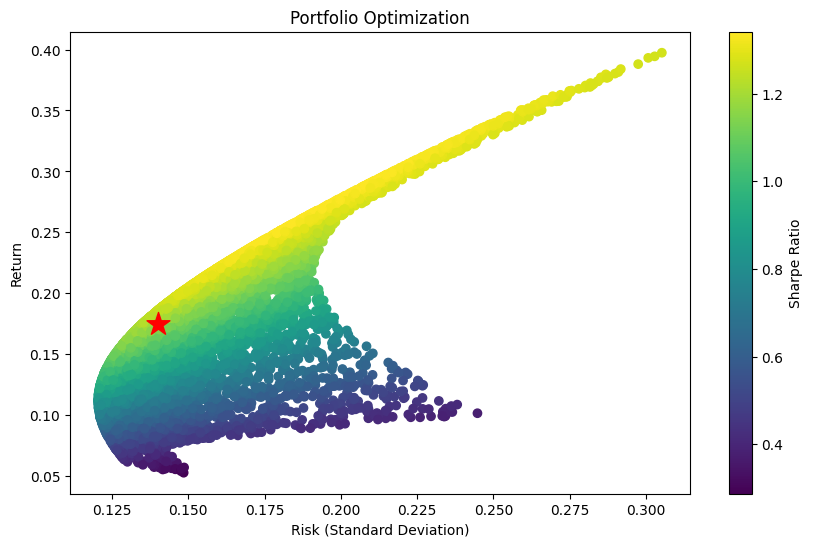

In [6]:
# Generate random portfolios for visualization
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)  # Normalize to sum to 1
    portfolio_std_dev, portfolio_return = portfolio_performance(weights, expected_returns, cov_matrix)
    results[0, i] = portfolio_std_dev
    results[1, i] = portfolio_return
    results[2, i] = (portfolio_return - 0.01) / portfolio_std_dev  # Sharpe Ratio

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(portfolio_std_dev, portfolio_return, color='red', marker='*', s=300)  # Optimal portfolio
plt.title('Portfolio Optimization')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.show()

In [8]:
tickers = ['BND']

In [9]:
import yfinance as yf
BND_stock_data = yf.download(tickers, start='2015-01-01', end='2024-10-31')

[*********************100%***********************]  1 of 1 completed


In [10]:
# Display the first few rows of the data
print(BND_stock_data.head())

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2015-01-02  82.430000  82.690002  82.419998  82.650002  63.358730  2218800
2015-01-05  82.739998  82.919998  82.699997  82.889999  63.542725  5820100
2015-01-06  83.029999  83.379997  83.029999  83.129997  63.726704  3887600
2015-01-07  83.139999  83.279999  83.050003  83.180000  63.765060  2433400
2015-01-08  83.110001  83.110001  82.970001  83.050003  63.665401  1873400


In [11]:
BND_stock_data.to_csv('../data/BND_stock_data.csv')

In [12]:
tickers = ['SPY']

In [13]:
import yfinance as yf
SPY_stock_data = yf.download(tickers, start='2015-01-01', end='2024-10-31')

[*********************100%***********************]  1 of 1 completed


In [14]:
# Display the first few rows of the data
print(SPY_stock_data.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02  206.380005  206.880005  204.179993  205.429993  173.173798   
2015-01-05  204.169998  204.369995  201.350006  201.720001  170.046265   
2015-01-06  202.089996  202.720001  198.860001  199.820007  168.444626   
2015-01-07  201.419998  202.720001  200.880005  202.309998  170.543671   
2015-01-08  204.009995  206.160004  203.990005  205.899994  173.569977   

               Volume  
Date                   
2015-01-02  121465900  
2015-01-05  169632600  
2015-01-06  209151400  
2015-01-07  125346700  
2015-01-08  147217800  


In [15]:
SPY_stock_data.to_csv('../data/SPY_stock_data.csv')

In [17]:
# Load historical data for TSLA, BND, and SPY
tsla_data = pd.read_csv('../data/TSLA_stock_data.csv', parse_dates=['Date'], index_col='Date')
bnd_data = pd.read_csv('../data/BND_stock_data.csv', parse_dates=['Date'], index_col='Date')
spy_data = pd.read_csv('../data/SPY_stock_data.csv', parse_dates=['Date'], index_col='Date')

# Extract closing prices
tsla_prices = tsla_data['Close']
bnd_prices = bnd_data['Close']
spy_prices = spy_data['Close']

# Combine the data into a single DataFrame
df = pd.DataFrame({'TSLA': tsla_prices, 'BND': bnd_prices, 'SPY': spy_prices})

In [22]:
# Define a function to fit SARIMA and forecast
def fit_sarima_and_forecast(data, order, seasonal_order, steps=252):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps)
    conf_int = model_fit.get_forecast(steps).conf_int()
    return forecast, conf_int

# Fit SARIMA and forecast for BND
bnd_order = (1, 1, 1)
bnd_seasonal_order = (1, 1, 1, 12)
bnd_forecast, bnd_conf_int = fit_sarima_and_forecast(bnd_prices, bnd_order, bnd_seasonal_order)

# Fit SARIMA and forecast for SPY
spy_order = (1, 1, 1)
spy_seasonal_order = (1, 1, 1, 12)
spy_forecast, spy_conf_int = fit_sarima_and_forecast(spy_prices, spy_order, spy_seasonal_order)


c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available.

In [23]:
# Create future dates for the forecast
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=252, freq='B')

In [24]:
# Create DataFrame for future forecasts
future_df = pd.DataFrame({
    'TSLA': np.nan,  # Placeholder for TSLA
    'BND': bnd_forecast,
    'SPY': spy_forecast
}, index=future_dates)

# Combine historical data with future forecasts
combined_df = pd.concat([df, future_df])

# Display combined DataFrame
print(combined_df)

                 TSLA        BND         SPY
2015-01-02  14.620667  82.650002  205.429993
2015-01-05  14.006000  82.889999  201.720001
2015-01-06  14.085333  83.129997  199.820007
2015-01-07  14.063333  83.180000  202.309998
2015-01-08  14.041333  83.050003  205.899994
...               ...        ...         ...
2025-10-13        NaN        NaN         NaN
2025-10-14        NaN        NaN         NaN
2025-10-15        NaN        NaN         NaN
2025-10-16        NaN        NaN         NaN
2025-10-17        NaN        NaN         NaN

[2726 rows x 3 columns]


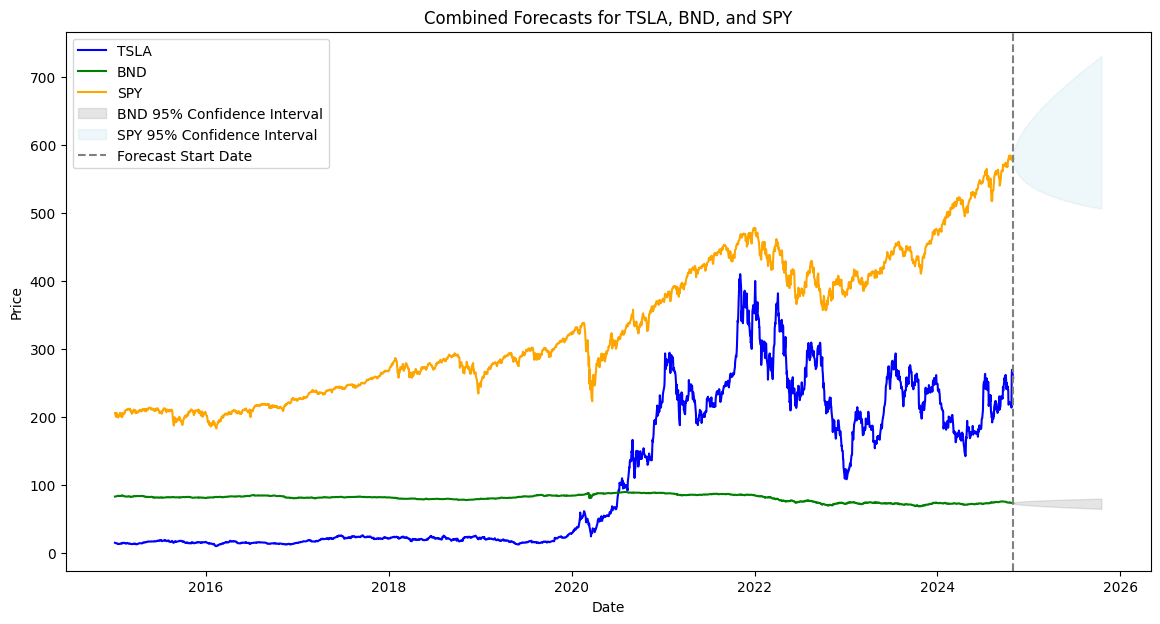

In [25]:
# Plot historical and forecasted prices
plt.figure(figsize=(14, 7))
plt.plot(combined_df.index, combined_df['TSLA'], label='TSLA', color='blue')
plt.plot(combined_df.index, combined_df['BND'], label='BND', color='green')
plt.plot(combined_df.index, combined_df['SPY'], label='SPY', color='orange')

# Plot confidence intervals for BND
plt.fill_between(future_dates, 
                 bnd_conf_int.iloc[:, 0], 
                 bnd_conf_int.iloc[:, 1], 
                 color='gray', alpha=0.2, label='BND 95% Confidence Interval')

# Plot confidence intervals for SPY
plt.fill_between(future_dates, 
                 spy_conf_int.iloc[:, 0], 
                 spy_conf_int.iloc[:, 1], 
                 color='lightblue', alpha=0.2, label='SPY 95% Confidence Interval')

plt.title('Combined Forecasts for TSLA, BND, and SPY')
plt.xlabel('Date')
plt.ylabel('Price')
plt.axvline(x=last_date, color='gray', linestyle='--', label='Forecast Start Date')
plt.legend()
plt.show()